In [4]:
# Importing the libraries
#import warnings
#import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sn
#plt.style.use('fivethirtyeight')
#import pandas_datareader as pdr
#import pandas as pd
#from sklearn.preprocessing import MinMaxScaler

#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional 
#import math
from sklearn.metrics import mean_squared_error
#from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

%matplotlib inline
warnings.filterwarnings('ignore') #Supressing warnings
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",500)
pd.set_option("display.max_colwidth",5000)

ModuleNotFoundError: No module named 'fix_yahoo_finance'

# EDA

In [2]:
#First, we get the data
dataset = pd.read_csv("DataFrame.csv", index_col='Date', parse_dates=['Date'])
dataset.head()

,Type,Time,open,high,low,close,Unnamed: 7
Date,,,,,,,
2021-01-01,NIFTY,09:16,13997.90,14020.85,13991.35,14013.15,NaN
2021-01-01,NIFTY,09:17,14014.85,14018.55,14008.15,14009.05,NaN
2021-01-01,NIFTY,09:18,14008.05,14013.10,14005.05,14012.70,NaN
2021-01-01,NIFTY,09:19,14013.65,14019.10,14013.65,14016.20,NaN
2021-01-01,NIFTY,09:20,14015.45,14017.80,14011.95,14015.45,NaN


In [3]:
dataset=dataset.drop(["Unnamed: 7","Type"],1)
dataset["Time"]=dataset["Time"].str.replace(":",".").astype("float")

dataset.head()

,Time,open,high,low,close
Date,,,,,
2021-01-01,9.16,13997.90,14020.85,13991.35,14013.15
2021-01-01,9.17,14014.85,14018.55,14008.15,14009.05
2021-01-01,9.18,14008.05,14013.10,14005.05,14012.70
2021-01-01,9.19,14013.65,14019.10,14013.65,14016.20
2021-01-01,9.20,14015.45,14017.80,14011.95,14015.45


In [4]:
dataset.describe(percentiles=(.25,.5,.75,.95,.99))

,Time,open,high,low,close
count,22805.000000,22805.000000,22805.000000,22805.000000,22805.000000
mean,12.203202,14703.322396,14707.486481,14699.102201,14703.260816
std,1.841618,391.377498,391.265231,391.551643,391.366248
min,9.080000,13604.750000,13614.400000,13596.750000,13602.800000
25%,10.490000,14462.250000,14465.950000,14458.050000,14461.950000
50%,12.240000,14739.500000,14743.000000,14735.850000,14739.450000
75%,13.590000,15037.000000,15041.250000,15032.500000,15036.850000
95%,15.150000,15244.550000,15247.300000,15240.920000,15243.940000
99%,15.300000,15321.740000,15326.186000,15319.198000,15321.998000
max,17.020000,15429.500000,15431.750000,15427.900000,15430.200000


In [5]:
# Show the info 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22805 entries, 2021-01-01 to 2021-03-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    22805 non-null  float64
 1   open    22805 non-null  float64
 2   high    22805 non-null  float64
 3   low     22805 non-null  float64
 4   close   22805 non-null  float64
dtypes: float64(5)
memory usage: 1.0 MB


In [6]:
#checking for null values if any in the datset 

round(dataset.isnull().sum()/len(dataset.index)*100,2)

Time     0.0
open     0.0
high     0.0
low      0.0
close    0.0
dtype: float64

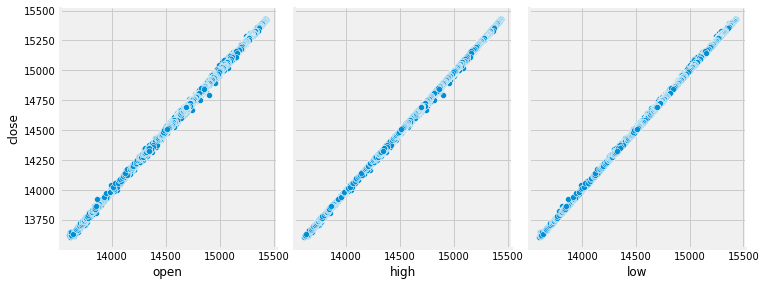

In [7]:
#Finding Correlation between columns

sn.pairplot(dataset, x_vars=['open','high','low'],y_vars=["close"],aspect=0.9,size=4,diag_kind=None)
plt.show()

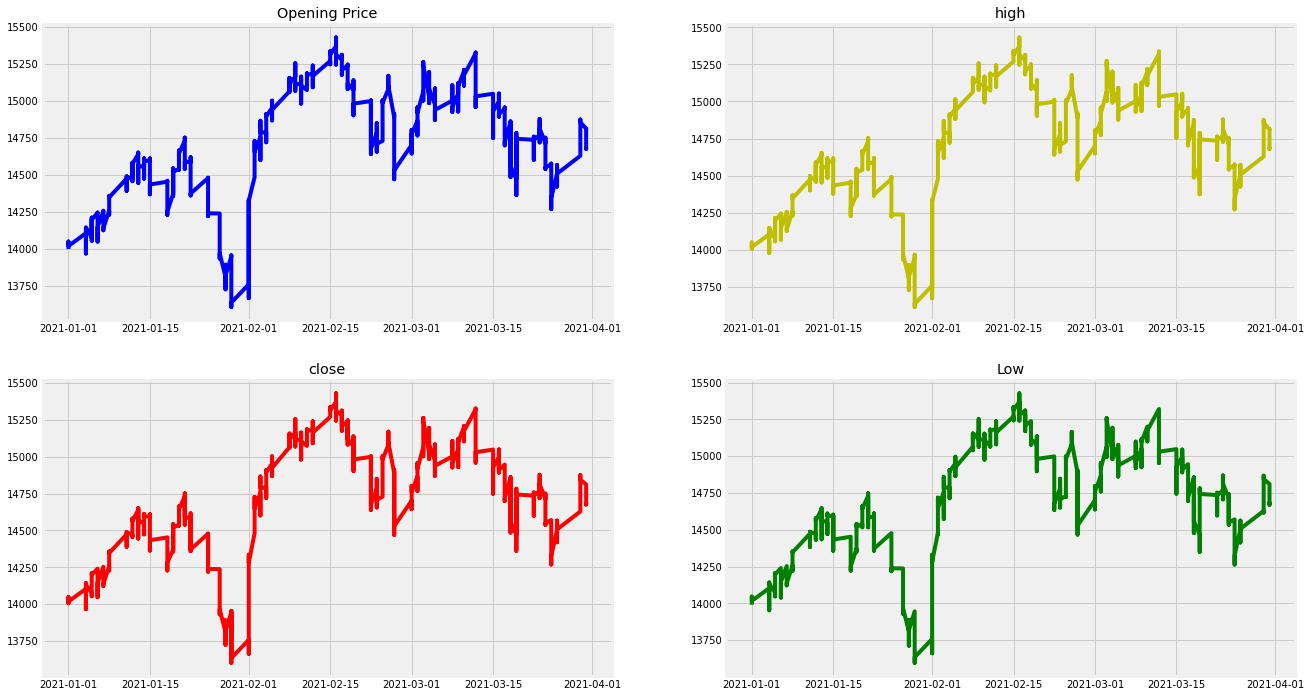

In [8]:
figure, axis = plt.subplots(2, 2,figsize=(20,12))
    
# For Opening Price
axis[0, 0].plot(dataset['open'],color='b')
axis[0, 0].set_title("Opening Price")
  
# For Closing Price
axis[0, 1].plot(dataset['high'],color='y')
axis[0, 1].set_title("high")
  
# For High
axis[1, 0].plot(dataset['close'],color='r')
axis[1, 0].set_title("close")
  
# For Low
axis[1, 1].plot(dataset['low'],color='g')
axis[1, 1].set_title("Low")
  
# Combine all the operations and display
plt.show()

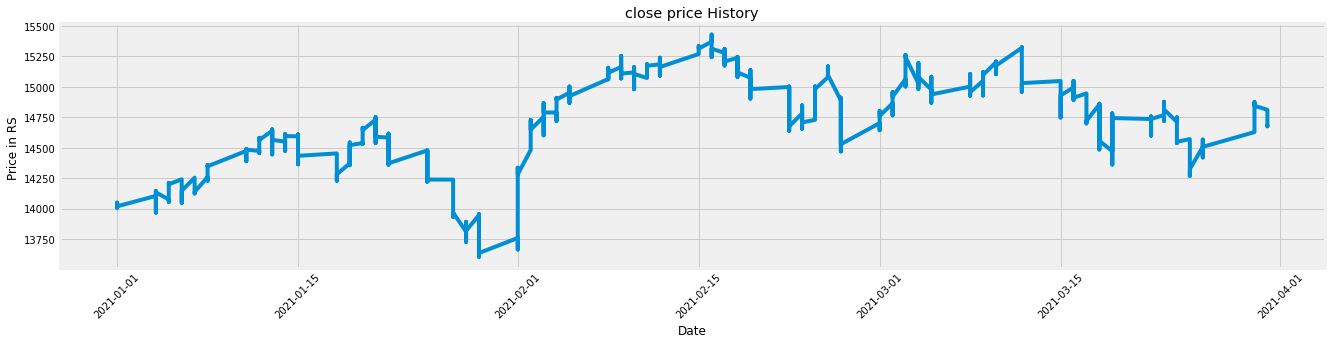

In [9]:
#Visually show the the stock price

plt.figure(figsize=(20.2,4.5))
plt.plot(dataset["close"],label="Close")
plt.title("close price History")
plt.xlabel("Date",)
plt.xticks(rotation=45)
plt.ylabel("Price in RS ")
plt.show()

## GRU

In [10]:
# Checking for missing values
training_set = dataset['2021-01-01':'2021-03-12'].iloc[:,4:5].values
test_set = dataset['2021-03-15':].iloc[:,4:5].values
test_set

array([[15048.4 ],
       [15002.6 ],
       [14998.1 ],
       ...,
       [14691.3 ],
       [14693.05],
       [14690.7 ]])

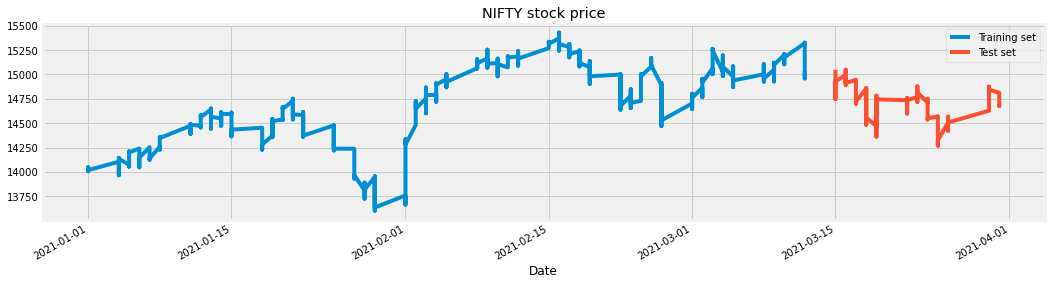

In [11]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["close"]['2021-01-01':'2021-03-12'].plot(figsize=(25,10),legend=True)
dataset["close"]['2021-03-15':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title("NIFTY"+' stock price')
plt.show()

In [12]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [13]:
# we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

previous = 30

for i in range(previous,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-previous:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(18240, 30, 1)

In [15]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=7,batch_size=32)

570/570 [==============================] - 22s 27ms/step - loss: 0.0211


In [48]:
# testing the model
dataset_total = pd.concat((dataset["close"][:'2021-02'],dataset["close"]['2021-03':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.fit_transform(inputs)
len(inputs)

4565

In [17]:
dataset_total=dataset_total[len(dataset_total)-len(test_set) - previous:]
dataset_total=pd.DataFrame(dataset_total)
dataset_total[:5]

,close
Date,
2021-03-12,15043.90
2021-03-12,15053.10
2021-03-12,15057.10
2021-03-12,15038.70
2021-03-12,15037.05


In [18]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(previous,len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

[14690.7] [14668.061]


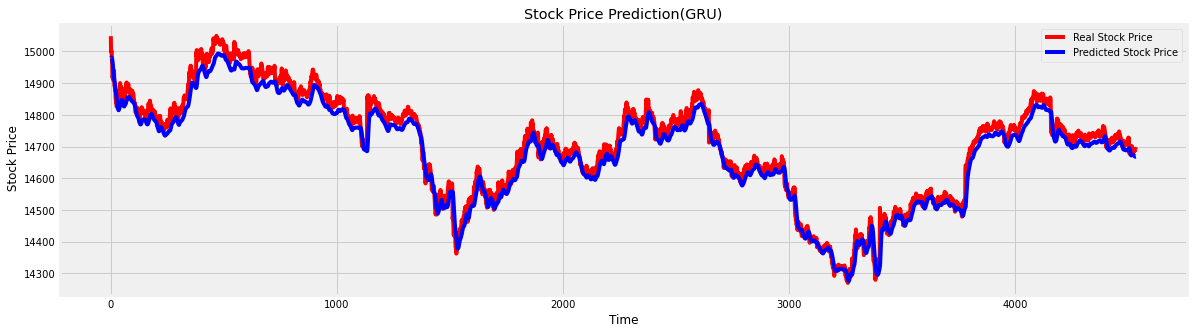

In [19]:
#Checking 
print(test_set[-1],predicted_stock_price[-1])


print
print
print
print


# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted Stock Price')
plt.title("Stock Price Prediction(GRU)")
plt.xlabel('Time')
plt.ylabel(" Stock Price")
plt.legend()
plt.show();

In [20]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 30.149698837417382.


4535
4535



Previous Day Pred [14856.331]
Next day Pred [14850.282]
Prediction Diffrence [-6.048828]



Actual prev Day Price [14852.5]
Actual next day price [14825.95]
Actual Diffrence [-26.55]








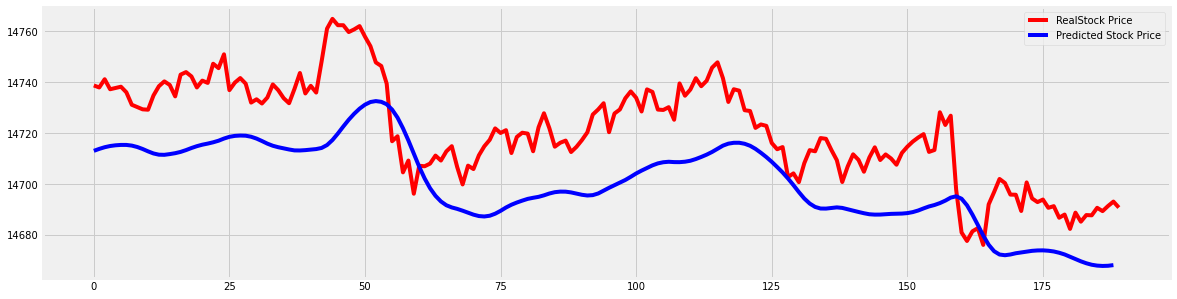

In [21]:
print(len(test_set))
print(len(predicted_stock_price))

print()
print()
print()

#Prediction Diffrence from prev day prediction to current day prediction 
prevday_pred = predicted_stock_price[25]
currentday_pred= predicted_stock_price[26]

diff =  currentday_pred - prevday_pred



#Actual Diffrence from prev day Actual price  to current day Actual price

_prev = test_set[25]
_current = test_set[26]

_diff = _current - _prev


#printing the results

print("Previous Day Pred",prevday_pred)
print("Next day Pred",currentday_pred)
print("Prediction Diffrence",diff)


print()
print()
print()

print("Actual prev Day Price",_prev)
print("Actual next day price",_current)
print("Actual Diffrence",_diff)


print()
print()
print()
print()
print()
print()

#plt/between original price and prediction price 
plt.figure(figsize=(18,5))
plt.plot(test_set[-190:], color='red',label='RealStock Price')
plt.plot(predicted_stock_price[-189:], color='blue',label='Predicted Stock Price')
plt.legend()
plt.show()

## **Finding % Increase and Classifying the price to labels "up" and "down"** 

In [22]:
results=dataset_total.tail(4535)
results["Predicted_Price"]=predicted_stock_price
results.columns=["Actaul Price","Predicted_Price"]
results["%_Change"]=results.Predicted_Price.pct_change(axis=0)
results["Class"]=np.where(results["Predicted_Price"].shift(-1)>results["Predicted_Price"],"up","Down")
results.tail()

,Actaul Price,Predicted_Price,%_Change,Class
Date,,,,
2021-03-31,14690.60,14668.200195,-0.000040,Down
2021-03-31,14689.30,14667.862305,-0.000023,Down
2021-03-31,14691.30,14667.729492,-0.000009,up
2021-03-31,14693.05,14667.795898,0.000005,up
2021-03-31,14690.70,14668.060547,0.000018,Down
